<a href="https://colab.research.google.com/github/sofiaborgato/Bioinformatic_project/blob/main/Alignment_result_classification_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler

In [ ]:
!git clone 'https://github.com/sofiaborgato/Bioinformatic_project.git'

Cloning into 'Bioinformatic_project'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [ ]:
import tarfile
import os
# open file
file = tarfile.open('./Bioinformatic_project/data.tar.xz') 
# extracting file
file.extractall('./Bioinformatic_project')
  
file.close()

In [ ]:
usa = pd.read_csv('./Bioinformatic_project/us_alignment.csv')
bra = pd.read_csv('./Bioinformatic_project/bra_alignment.csv')
ori = pd.read_csv('./Bioinformatic_project/ori_alignment.csv')
eng = pd.read_csv('./Bioinformatic_project/en1_alignment.csv')
eng_2 =pd.read_csv('./Bioinformatic_project/en2_alignment.csv')
sa=pd.read_csv('./Bioinformatic_project/afri_alignment.csv')

In [ ]:

label_usa=np.ones(len(usa))
usa['label']=label_usa

label_bra=np.ones(len(bra))*2
bra['label']=label_bra


label_ori=np.zeros(len(ori))
ori['label']=label_ori

label_e_1=np.ones(len(eng))*3
eng['label']=label_e_1


label_e_2=np.ones(len(eng_2))*4
eng_2['label']=label_e_2


label_afri=np.ones(len(sa))*5
sa['label']=label_afri


n_samples = 1000

usa=usa.sample(n = n_samples)
ori=ori.sample(n = n_samples)
bra=bra.sample(n = n_samples)
eng=eng.sample(n = n_samples)
eng_2=eng_2.sample(n = n_samples)
sa=sa.sample(n = n_samples)

In [ ]:
datasets=[usa,ori,bra,eng,eng_2,sa]
total=pd.concat(datasets,ignore_index=True)



In [ ]:
variants = { 0 : 'ori', 1 : 'usa', 2 : 'bra', 3 : 'eng', 4 : 'eng_2', 5: 'sud_af' }

In [ ]:
labels_name = []
for i in total.label:
    lab = int(i)
    labels_name.append(variants[lab])
total['labels_name'] = labels_name

# Data Exploration


In [ ]:
dt=total.copy()


In [ ]:

dt.columns


Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF6',
       'mis_ORF7a', 'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_ORF10', 'mis_OTHER',
       'gap_ORF1ab', 'gap_S', 'gap_ORF3a', 'gap_E', 'gap_M', 'gap_ORF6',
       'gap_ORF7a', 'gap_ORF7b', 'gap_ORF8', 'gap_N', 'gap_ORF10', 'gap_OTHER',
       'label', 'labels_name'],
      dtype='object')

##Correlations
A factor that could affect good performance of the analysis is the correlation between attributes because most of  classification algorithms assume that all the predictors are indipendent.
For this porpuse Persaons's coeficient is calculatated as followed for each couple of random vector (X,Y):
$$\rho_{x,y}=\frac{Cov(X,Y)}{\sigma_x \sigma_y
}$$

Correlation is a normalization of the covariance by $\sigma_x$,$\sigma_y$, the respectivily standard deviation of X,Y.This number is in range [-1,1] and it measures the strenght of the correlations between X and Y. The higher the module of the value the strongher the correlation. 
It's important to note that $\rho$ represent only linear correlations and so a value of $\rho$ near by zero doesn't indicate necessarly absence of correlation. Can also means strong non linear correlation. 

In order to visualize the correlation between features I plot the following heatmap. The correlation is set to be in range [-1,1], and is max for dark purple.

We can observe that there are many features that have really high correlations and so a feature selection procedure for dimentsionality reducion is needed during preprocessing step. 

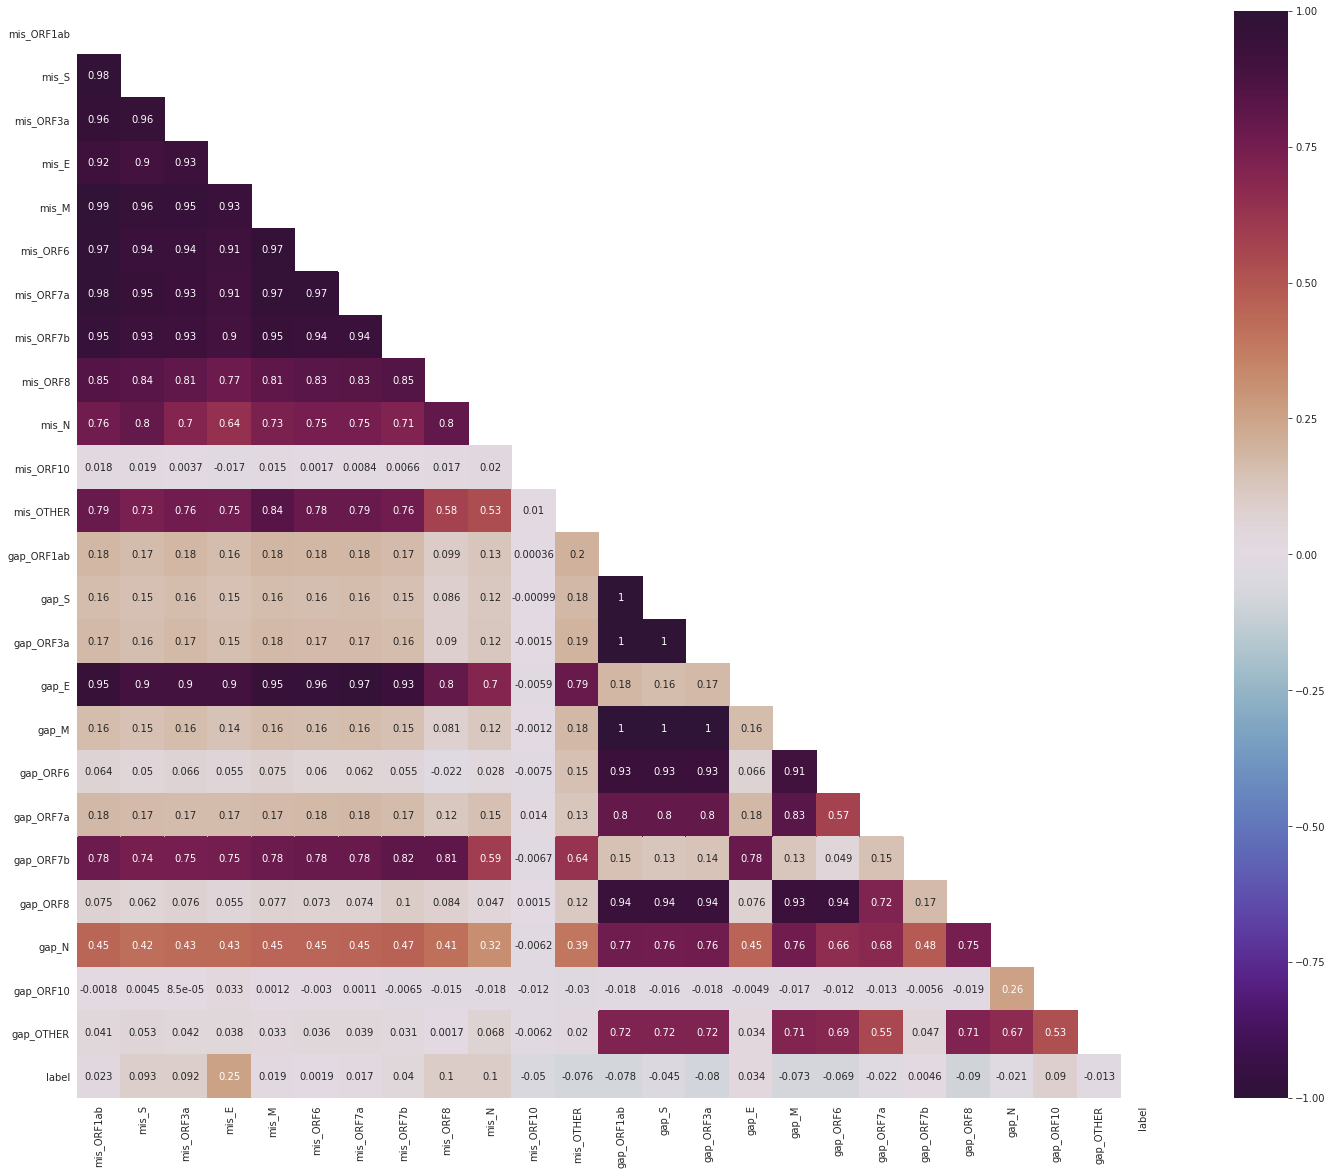

In [ ]:
cor_matrix=dt.corr()
mask = np.triu(np.ones_like(cor_matrix, dtype=bool))
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25,20))
    ax = sns.heatmap(cor_matrix,mask=mask, square=True,cmap="twilight_shifted",vmin=-1,vmax=1,annot=True)

In [ ]:
columns=dt.columns
columns

Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF6',
       'mis_ORF7a', 'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_ORF10', 'mis_OTHER',
       'gap_ORF1ab', 'gap_S', 'gap_ORF3a', 'gap_E', 'gap_M', 'gap_ORF6',
       'gap_ORF7a', 'gap_ORF7b', 'gap_ORF8', 'gap_N', 'gap_ORF10', 'gap_OTHER',
       'label'],
      dtype='object')

In [ ]:
corr=dt.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.90:
            if columns[j]:
                columns[j] = False
selected_columns = dt.columns[columns]
unsup_df=dt[selected_columns]
print(selected_columns)


print(len(selected_columns))

Index(['mis_ORF1ab', 'mis_ORF8', 'mis_N', 'mis_ORF10', 'mis_OTHER',
       'gap_ORF1ab', 'gap_ORF7a', 'gap_ORF7b', 'gap_N', 'gap_ORF10',
       'gap_OTHER', 'label'],
      dtype='object')
12


# Preprocessing

## Standardization
The data exploration phase shows that features has widespread range of values , with different means and standard deviations. That can affect the correctness of the classification task because features with greater variance can influence more the objective function. In addition, many cassifications algorithms assume that data are zero centerend and with unit variance. So we concluded that a standardization tecnique was needed.

So independently for each feature we subtracted the mean and divided for the standard devitaion of the current feature.

The mean and the standard deviation are computed only taking into account the training-set, and the transformation is then applied to the test-set because usally in the initial phase the test set is unknown. It's formally uncorrected taking into account during training procedure any kind of information relative with the test set.

In the plot below we can visualize the standardized outputs.

In [ ]:

ss=StandardScaler()
qt=QuantileTransformer()
rs=RobustScaler()
dt_norm=ss.fit_transform(dt.drop(columns=['label','labels_name']))
dt_qt=qt.fit_transform(dt.drop(columns=['label','labels_name']))
dt_rs=rs.fit_transform(dt.drop(columns=['label','labels_name']))



In [ ]:
clm_names=['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF6',
       'mis_ORF7a', 'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_ORF10', 'mis_OTHER',
       'gap_ORF1ab', 'gap_S', 'gap_ORF3a', 'gap_E', 'gap_M', 'gap_ORF6',
       'gap_ORF7a', 'gap_ORF7b', 'gap_ORF8', 'gap_N', 'gap_ORF10', 'gap_OTHER']
dt_ss=pd.DataFrame(dt_norm,columns=clm_names)
dt_qt=pd.DataFrame(dt_qt,columns=clm_names)
dt_rs=pd.DataFrame(dt_rs,columns=clm_names)

In [ ]:
dt_qt

,mis_ORF1ab,mis_S,mis_ORF3a,mis_E,mis_M,mis_ORF6,mis_ORF7a,mis_ORF7b,mis_ORF8,mis_N,mis_ORF10,mis_OTHER,gap_ORF1ab,gap_S,gap_ORF3a,gap_E,gap_M,gap_ORF6,gap_ORF7a,gap_ORF7b,gap_ORF8,gap_N,gap_ORF10,gap_OTHER
0,0.228228,0.180180,0.543043,0.000000,0.768769,0.0,0.0,0.000000,0.000000,0.347848,0.0,0.762262,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.847347,0.435435,0.543043,0.000000,0.768769,0.0,0.0,0.000000,0.000000,0.347848,0.0,0.933934,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.275275,0.288288,0.543043,0.000000,0.768769,0.0,0.0,0.000000,0.000000,0.347848,0.0,0.933934,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.228228,0.180180,0.543043,0.000000,0.768769,0.0,0.0,0.000000,0.000000,0.512012,0.0,0.762262,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.464965,0.288288,0.543043,0.000000,0.768769,0.0,0.0,0.000000,0.562563,0.347848,0.0,0.762262,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.228228,0.629630,0.985485,0.993994,0.000000,0.0,0.0,0.000000,0.562563,0.204705,0.0,0.000000,0.65015,0.723724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5996,0.228228,0.435435,0.822823,0.834334,0.000000,0.0,0.0,0.968969,0.562563,0.347848,0.0,0.000000,0.65015,0.723724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,0.464965,0.765766,0.949449,0.834334,0.000000,0.0,0.0,0.000000,0.562563,0.204705,0.0,0.000000,0.65015,0.723724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5998,0.464965,0.435435,0.822823,0.834334,0.768769,0.0,0.0,0.000000,0.562563,0.347848,0.0,0.762262,0.65015,0.723724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dt_ss['label']=total['labels_name']
dt_qt['label']=total['labels_name']
dt_rs['label']=total['labels_name']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


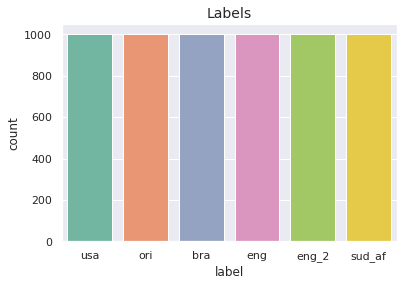

In [ ]:
dt_c = dt_ss

sns.set_theme(style="darkgrid")
sns.countplot(dt_c['label'], data=total,palette="Set2",)
plt.title('Labels', fontsize=14)
plt.show()

<Figure size 1800x1440 with 0 Axes>

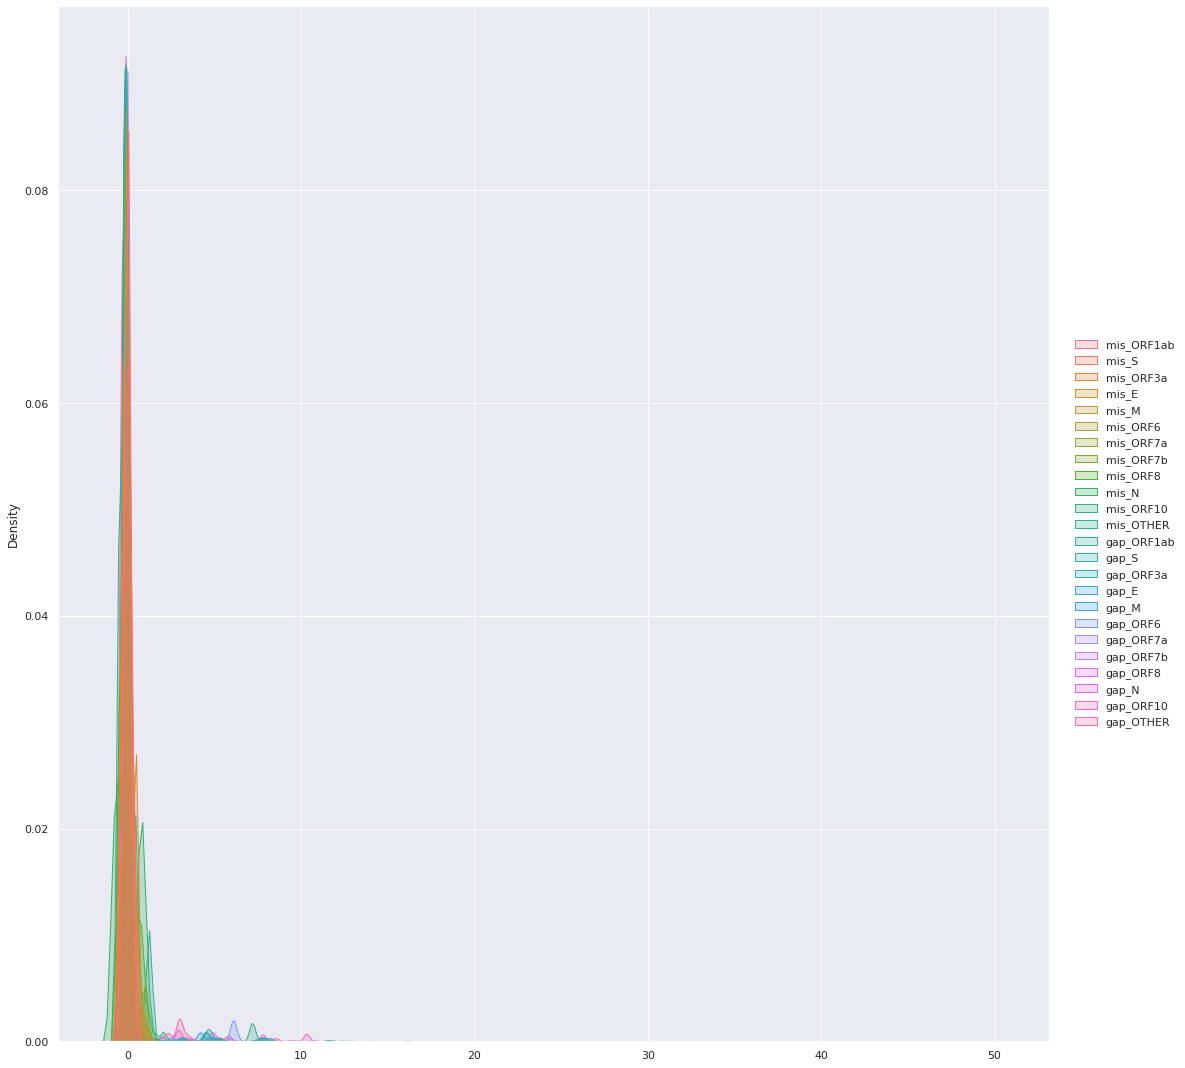

In [ ]:
plt.figure(figsize=(25, 20))

sns.displot(data=dt_c,kind="kde", fill=True,height=15)

<Figure size 1800x1440 with 0 Axes>

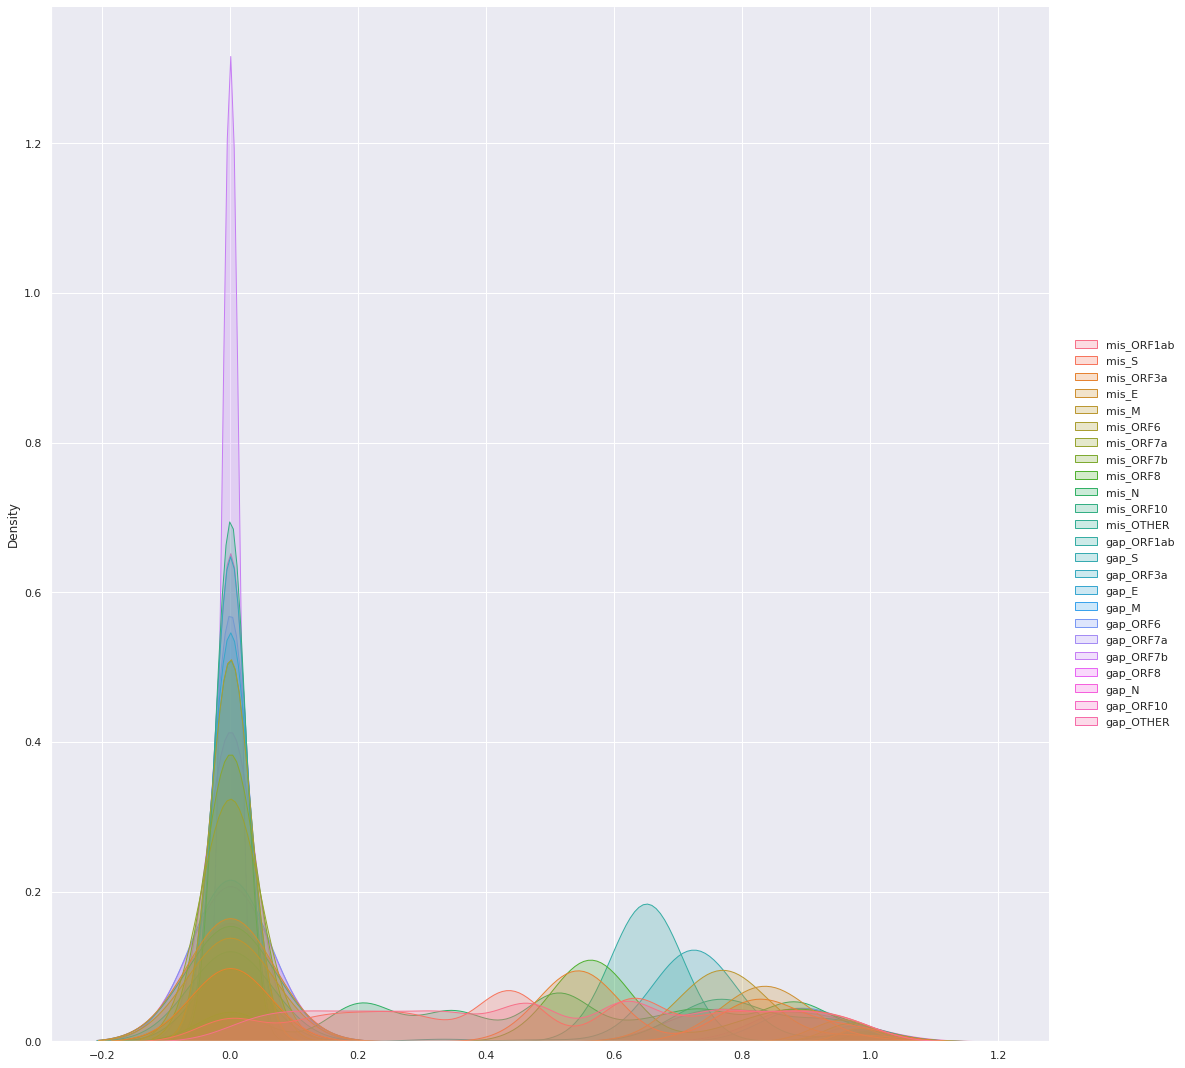

In [ ]:
plt.figure(figsize=(25, 20))

sns.displot(data=dt_qt,kind="kde", fill=True,height=15)

<Figure size 1800x1440 with 0 Axes>

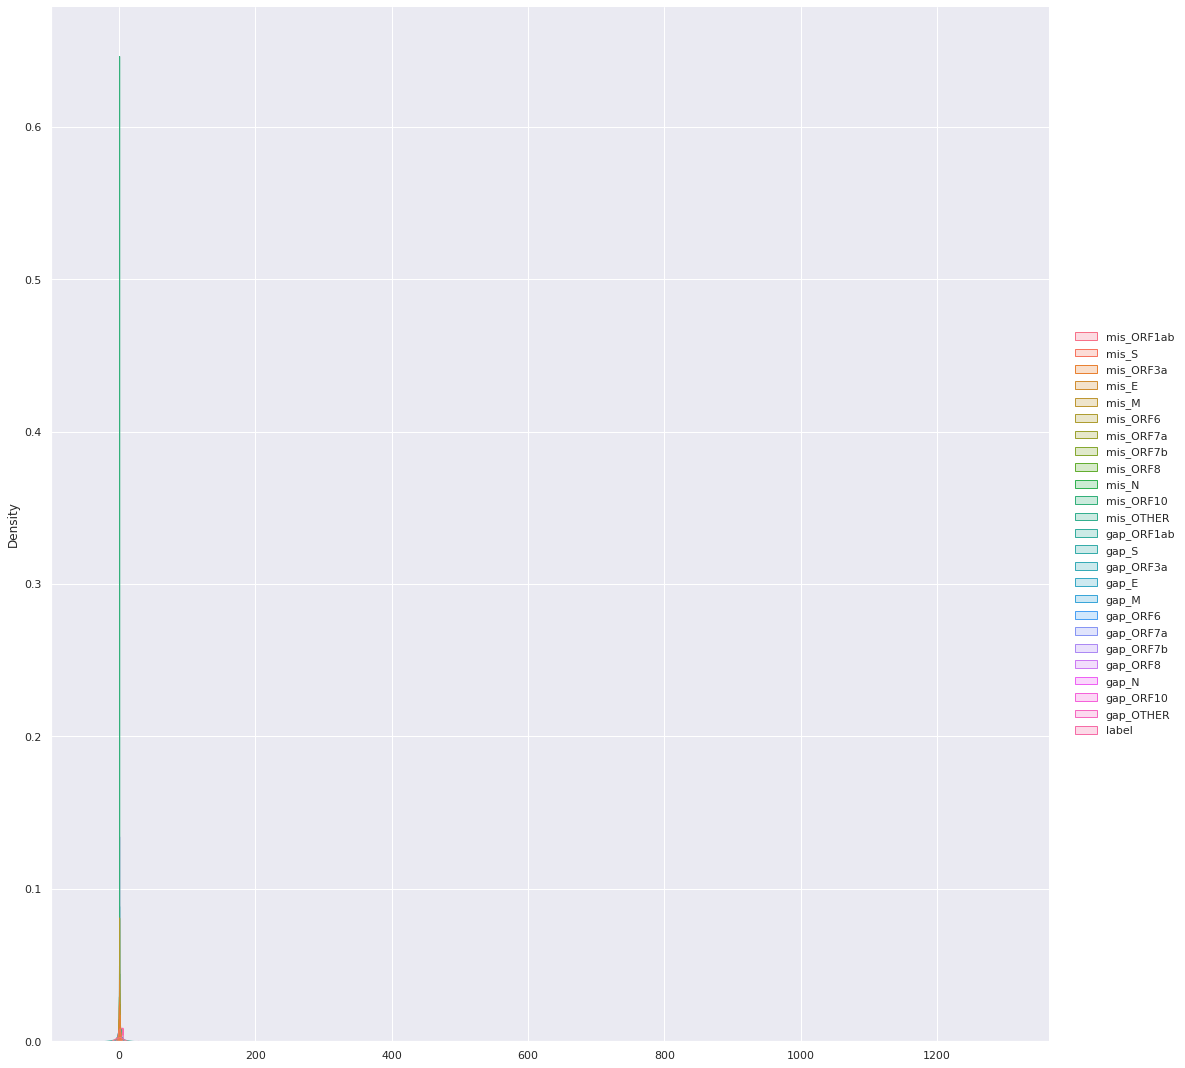

In [ ]:
plt.figure(figsize=(25, 20))

sns.displot(data=dt_rs,kind="kde", fill=True,height=15)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

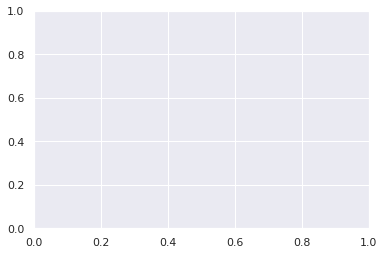

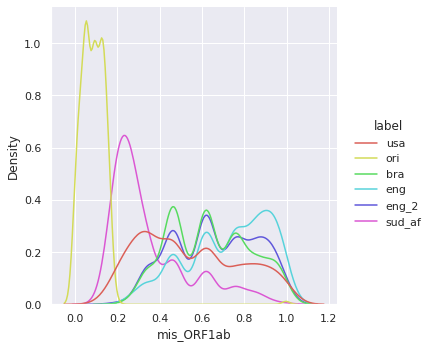

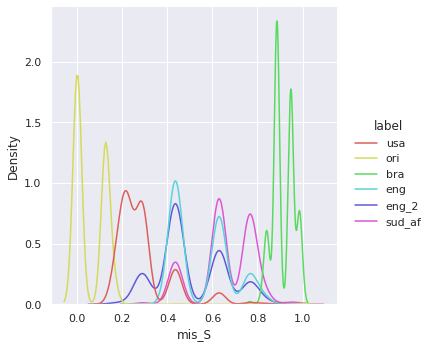

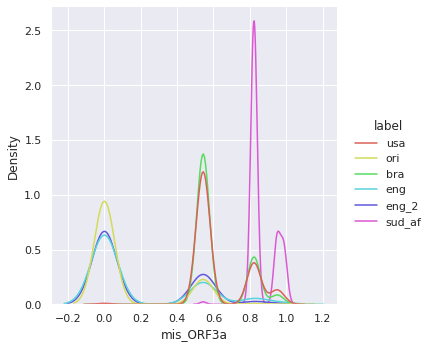

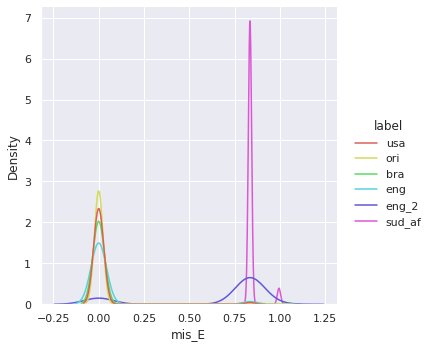

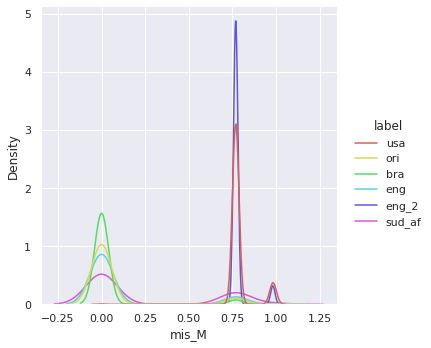

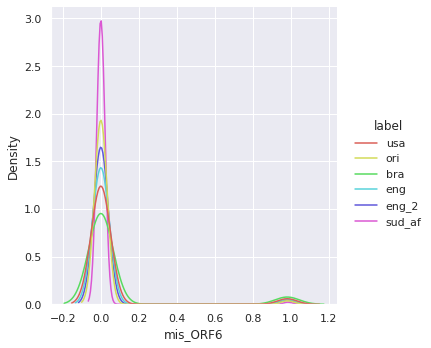

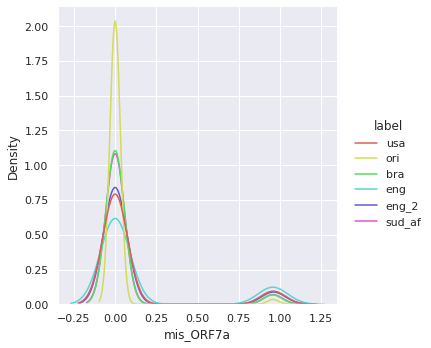

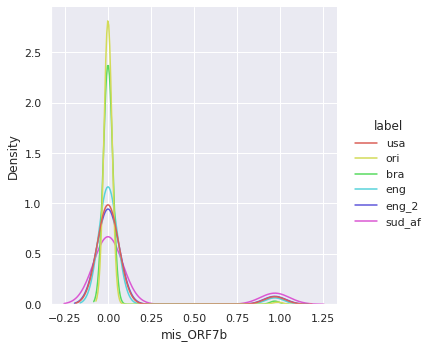

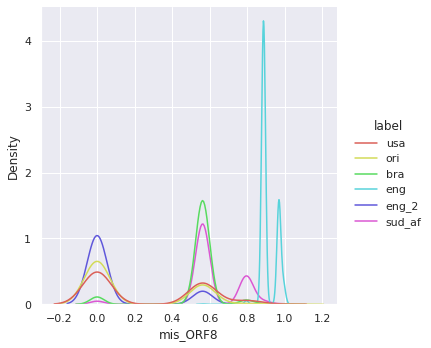

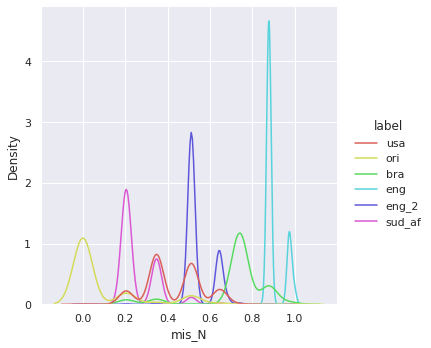

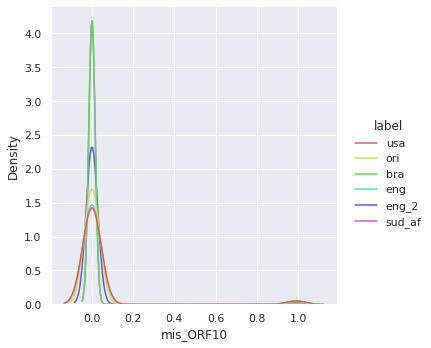

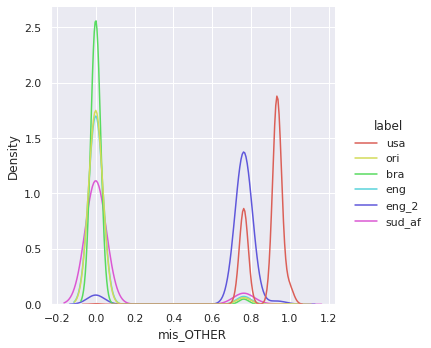

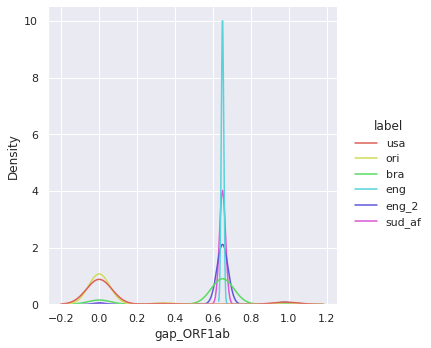

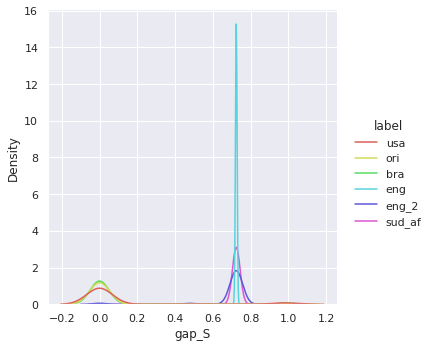

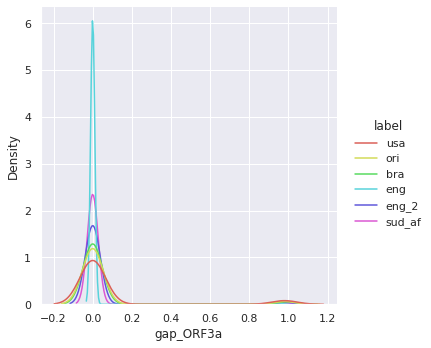

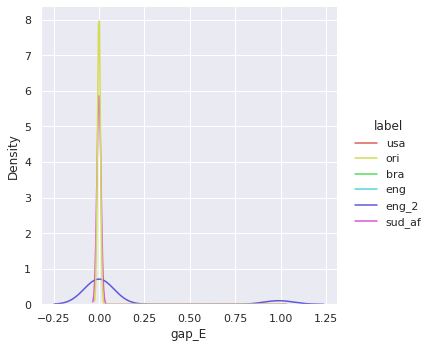

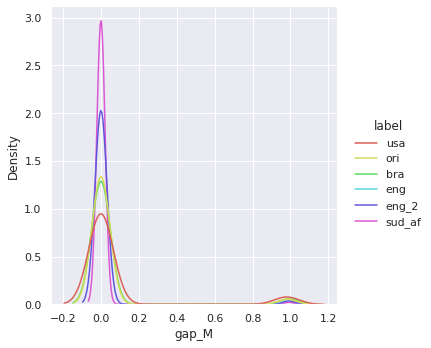

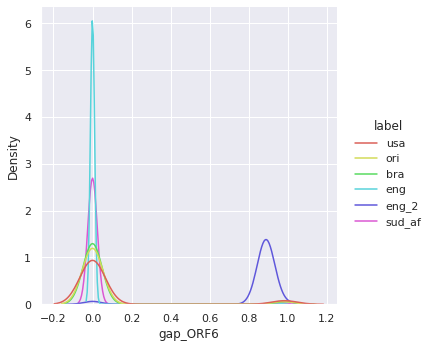

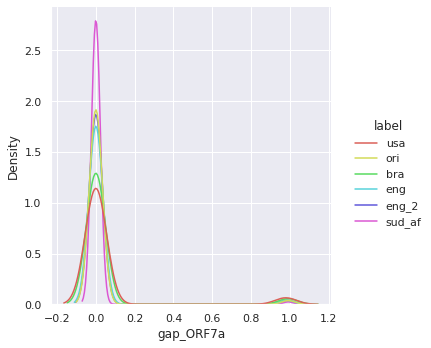

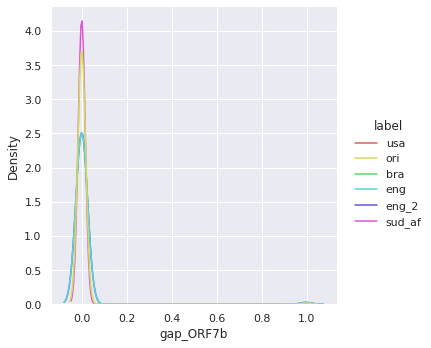

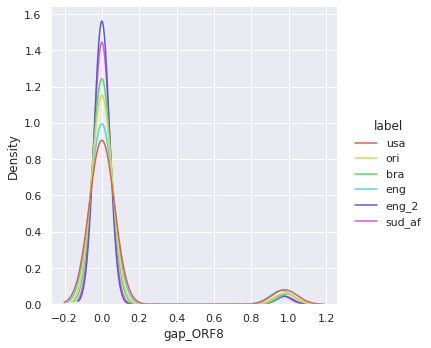

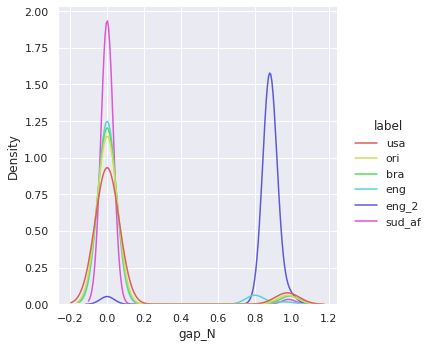

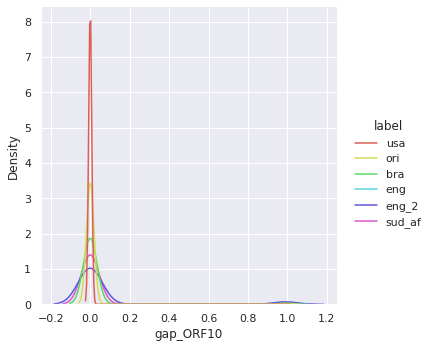

In [ ]:
fig = plt.subplots(num=24, clear=True)
for i in range (0,len(clm_names)-1):
  fig=sns.displot(data=dt_qt, x=clm_names[i], hue='label', kind="kde",palette=sns.color_palette('hls',6))

#Integer encoding for the label

In [ ]:
y=dt_qt['label']
dt_qt.drop(columns='label',inplace=True)

In [ ]:
#TODO:bisogna mettere lo scaler dopo aver diviso in train e test
x_train,x_test,y_train,y_test=train_test_split(dt_qt,y,test_size=0.1, shuffle=True, stratify=y)
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

In [ ]:
x_train.shape


(5400, 24)

In [ ]:
# integer encode
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# Random Forest with select k_best


Stratifierd k-fold cross validation strategy in order to find best k value.

In [ ]:

kbest=[5,10,15,20,24]

skf = StratifiedKFold(n_splits=5)
from sklearn.metrics import fbeta_score
all=[]
for k in kbest:
  x=SelectKBest(k=k).fit_transform(x_train,y_train)
  acc=[]
  for train_index, test_index in skf.split(x, y_train):
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    pred=rf.predict(X_test)
    acc.append(fbeta_score(pred,Y_test,beta=2,average='macro'))
    
  s=np.mean(acc)
  all.append(s)
  print('F2_score for n_features:'+str(k))
  print(np.mean(acc))

print('Best number of features:'+str(kbest[np.argmax(all)]))
print('F2_score:'+str(np.max(all)))


    






[[ 1.54483669 -0.68240954  0.83238298 -0.73444684 -1.04527529]
 [ 1.18082804 -0.68240954  0.83238298 -0.73444684 -1.04527529]
 [ 0.45622867 -0.68240954  1.29468109 -0.73444684  0.90133866]
 ...
 [-0.20684811 -0.68240954  0.06580865  1.18751204 -1.04527529]
 [-1.14164966 -0.68240954 -1.65394032 -0.73444684 -1.04527529]
 [-1.693644   -0.68240954 -1.65394032 -0.73444684 -1.04527529]]
F2_score for n_features:5
0.9902581316025225
[[ 1.54483669  0.31044272 -0.68240954 ... -1.04527529 -0.48384726
  -0.50787113]
 [ 1.18082804  0.31044272 -0.68240954 ... -1.04527529 -0.48384726
  -0.50787113]
 [ 0.45622867  0.31044272 -0.68240954 ...  0.90133866 -0.48384726
  -0.50787113]
 ...
 [-0.20684811 -1.22568997 -0.68240954 ... -1.04527529 -0.48384726
  -0.50787113]
 [-1.14164966 -1.22568997 -0.68240954 ... -1.04527529 -0.48384726
  -0.50787113]
 [-1.693644   -1.22568997 -0.68240954 ... -1.04527529 -0.48384726
  -0.50787113]]
F2_score for n_features:10
0.9974137058947428
[[-0.12240764  1.54483669  0.3104

## Test with Random Forest

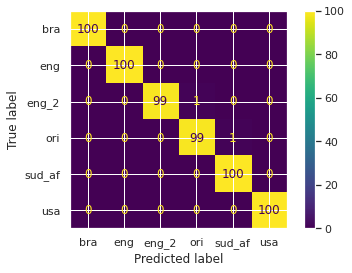

In [ ]:
from sklearn.metrics import confusion_matrix
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
pred=rf.predict(x_test)
s=fbeta_score(y_test,pred,beta=2,average='macro')

plot_confusion_matrix(rf,x_test,y_test,values_format='d')

In [ ]:
labels = ['0','1','2','3','4','5']

# Recursive Features Elimination

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 22
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF6',
       'mis_ORF7a', 'mis_ORF8', 'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S',
       'gap_ORF3a', 'gap_E', 'gap_M', 'gap_ORF6', 'gap_ORF7a', 'gap_ORF7b',
       'gap_ORF8', 'gap_N', 'gap_ORF10', 'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is:

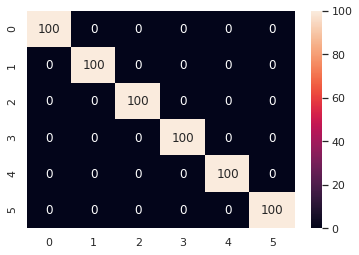

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 18
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF7b',
       'mis_ORF8', 'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S', 'gap_ORF3a',
       'gap_M', 'gap_ORF6', 'gap_ORF7a', 'gap_ORF8', 'gap_N', 'gap_OTHER'],
      dtype='object')
Recall is:  0.9983333333333334
Accuracy is:  0.9983333333333333
F1 score is:  0.998333291665625
Precision is: 0.9983498

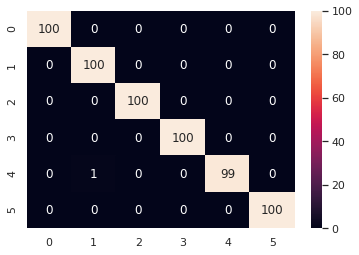

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 11
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_E', 'mis_M', 'mis_ORF8', 'mis_N',
       'mis_OTHER', 'gap_ORF1ab', 'gap_S', 'gap_ORF6', 'gap_N'],
      dtype='object')
Recall is:  0.9966666666666667
Accuracy is:  0.9966666666666667
F1 score is:  0.9966581235237951
Precision is: 0.9966996699669967


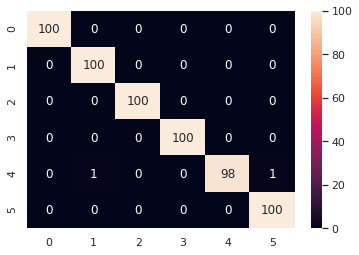

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 11
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_ORF8', 'mis_N',
       'mis_OTHER', 'gap_ORF1ab', 'gap_S', 'gap_ORF6', 'gap_N'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


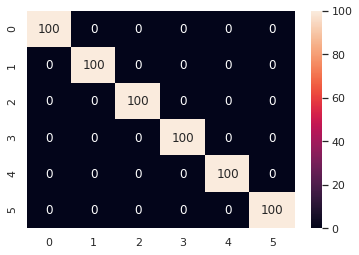

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 16
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF8',
       'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S', 'gap_ORF3a', 'gap_M',
       'gap_ORF6', 'gap_ORF8', 'gap_N', 'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


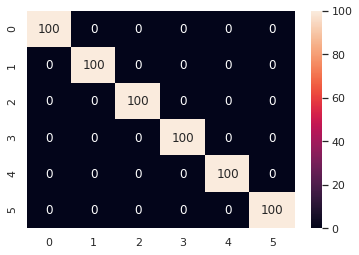

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 12
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF8',
       'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S', 'gap_ORF6', 'gap_N'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


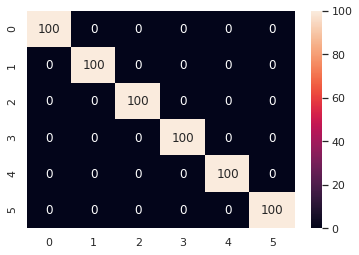

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 12
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF8',
       'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S', 'gap_ORF6', 'gap_N'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


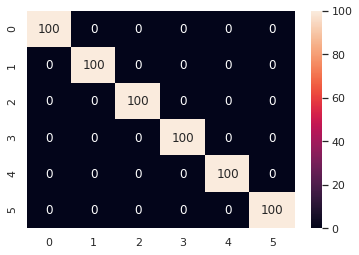

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 15
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF8',
       'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S', 'gap_ORF3a', 'gap_ORF6',
       'gap_ORF8', 'gap_N', 'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


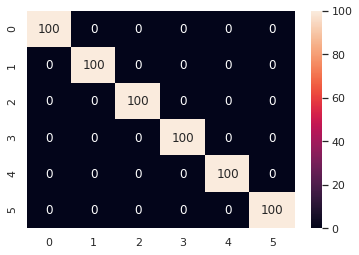

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 21
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF6',
       'mis_ORF7a', 'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_OTHER',
       'gap_ORF1ab', 'gap_S', 'gap_ORF3a', 'gap_E', 'gap_M', 'gap_ORF6',
       'gap_ORF8', 'gap_N', 'gap_ORF10', 'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


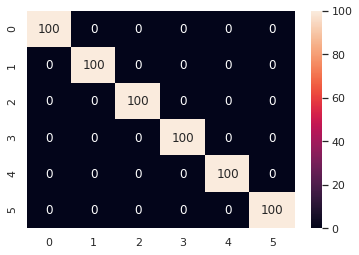

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 19
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF7a',
       'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S',
       'gap_ORF3a', 'gap_M', 'gap_ORF6', 'gap_ORF7a', 'gap_ORF8', 'gap_N',
       'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


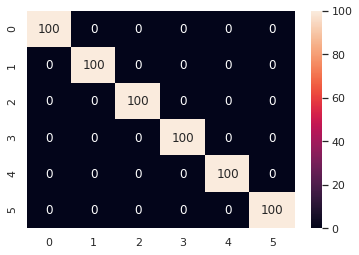

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 19
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF7a',
       'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S',
       'gap_ORF3a', 'gap_M', 'gap_ORF6', 'gap_ORF7a', 'gap_ORF8', 'gap_N',
       'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


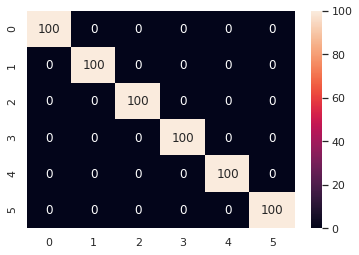

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 21
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF7a',
       'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S',
       'gap_ORF3a', 'gap_E', 'gap_M', 'gap_ORF6', 'gap_ORF7a', 'gap_ORF8',
       'gap_N', 'gap_ORF10', 'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


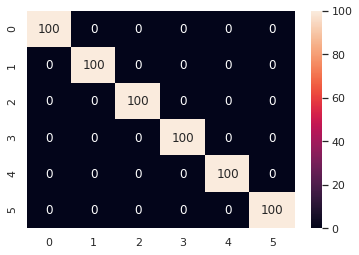

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 21
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF6',
       'mis_ORF7a', 'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_OTHER',
       'gap_ORF1ab', 'gap_S', 'gap_ORF3a', 'gap_E', 'gap_M', 'gap_ORF6',
       'gap_ORF8', 'gap_N', 'gap_ORF10', 'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


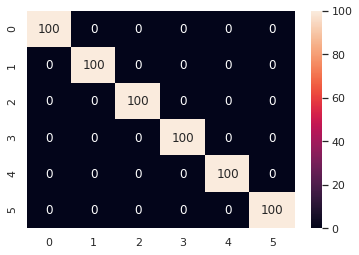

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 17
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF8',
       'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S', 'gap_ORF3a', 'gap_M',
       'gap_ORF6', 'gap_ORF7a', 'gap_ORF8', 'gap_N', 'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


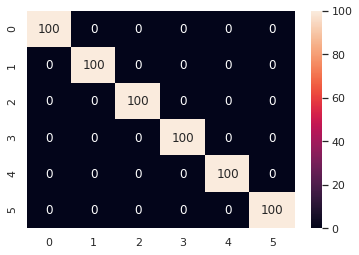

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 12
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF8',
       'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S', 'gap_ORF6', 'gap_N'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


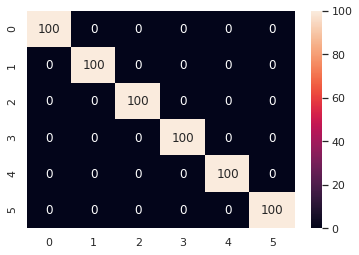

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
Optimal number of features : 21
Best features : Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF7a',
       'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S',
       'gap_ORF3a', 'gap_E', 'gap_M', 'gap_ORF6', 'gap_ORF7a', 'gap_ORF8',
       'gap_N', 'gap_ORF10', 'gap_OTHER'],
      dtype='object')
Recall is:  1.0
Accuracy is:  1.0
F1 score is:  1.0
Precision is: 1.0


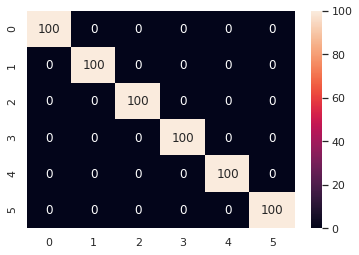

CONCLUSION:
best precision is: 1.0
max_deph: 20
num_of_estimato: 40
num_best_features 21
best_features= Index(['mis_ORF1ab', 'mis_S', 'mis_ORF3a', 'mis_E', 'mis_M', 'mis_ORF7a',
       'mis_ORF7b', 'mis_ORF8', 'mis_N', 'mis_OTHER', 'gap_ORF1ab', 'gap_S',
       'gap_ORF3a', 'gap_E', 'gap_M', 'gap_ORF6', 'gap_ORF7a', 'gap_ORF8',
       'gap_N', 'gap_ORF10', 'gap_OTHER'],
      dtype='object')


In [ ]:
#TRAIN WITH RFE On RF
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
max_deph=[5,10,15,20]
num_estimators=[10,20,30,40]
best=0
bd=0
mf=0
k=0
num_best=0
best_features=[]
for d in max_deph:
  for f in num_estimators:
    clf =RandomForestClassifier(random_state=42,max_depth=d,n_estimators=f) 
    rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='accuracy')   #5-fold cross-validation
    rfecv = rfecv.fit(x_train, y_train)
    print(clf.get_params)
    print('Optimal number of features :', rfecv.n_features_)
    print('Best features :', dt_qt.columns[rfecv.support_])
    recall = recall_score(y_test,rfecv.predict(x_test),average='macro')
    print('Recall is: ', recall)
    accuracy = accuracy_score(y_test,rfecv.predict(x_test))
    print('Accuracy is: ', accuracy)
    f1 = f1_score(y_test,rfecv.predict(x_test),average='macro')
    print('F1 score is: ', f1)
    cm = confusion_matrix(y_test,rfecv.predict(x_test))
    pre = precision_score(y_test,rfecv.predict(x_test),average='macro')
    print('Precision is:' ,pre)
    if pre>=best:
        best=precision_score(y_test,rfecv.predict(x_test),average='macro')
        bd=d
        mf=f
        num_best=rfecv.n_features_
        best_features=dt_qt.columns[rfecv.support_]
        
      
  
    plt.figure()
    sns.heatmap(cm,annot=True,fmt="d")
    plt.show()
print('CONCLUSION:')
print('best precision is:',best)
print('max_deph:',bd)
print('num_of_estimato:',mf)
print('num_best_features',num_best)
print('best_features=',best_features)

# SVM with PCA

In [ ]:
data = total.copy()

y=data['label'].astype('category')
data.drop(columns=['label','labels_name'],inplace=True)
x = data

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1, shuffle=True, stratify=y)


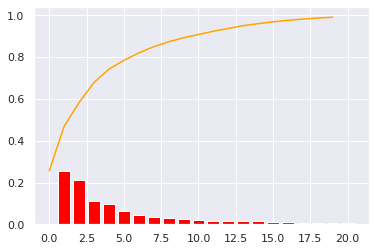

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer


# scaling data
#z_norm = StandardScaler()
#data_standard = z_norm.fit_transform(data)
qt=QuantileTransformer()
x_train=qt.fit_transform(x_train)
x_test=qt.transform(x_test)

# PCA before and after scalarization
n = 20
pca = PCA(n_components = n, svd_solver = 'full')
pca.fit(data)
projected=pca.fit_transform(x_train)

# cumulative variance before and after scalarization
cumvar = np.zeros([n,1])
for i in range(n):
  cumvar[i] = sum(pca.explained_variance_ratio_[:i+1])

# plots before and after scalarization
plt.bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_ratio_ , color = 'red')
plt.plot(cumvar,color = 'orange')



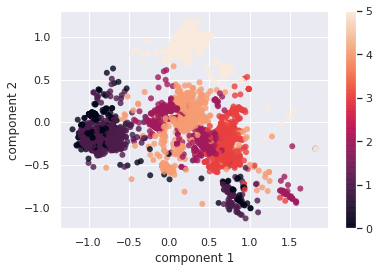

In [ ]:

plt.scatter(projected[:, 1], projected[:, 2],c=y_train, edgecolor='none', alpha=0.8,marker='o')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [ ]:
pca=PCA(n_components=4)
x_train=pca.fit_transform(x_train)
x_test=pca.transform(x_test)

PCA with 4 components

In [ ]:
from sklearn.svm import SVC
svm=SVC()
svm.fit(x_train,y_train)
pred=svm.predict(x_test)
score=fbeta_score(y_test,pred,beta=2,average='macro')

In [ ]:
print(score)

0.9882908444543449
